## Twitter Analysis

In [48]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import json

from sklearn.metrics import classification_report, confusion_matrix

In [49]:
import tarfile
tar = tarfile.open("output.tar.gz")
tar.extractall()
tar.close()

In [50]:
ls

 Volume in drive C is Windows
 Volume Serial Number is CC27-3DF1

 Directory of C:\Git\AmazonSageMakerCourse\AIServices\TwitterFeed

10/18/2019  04:06 PM    <DIR>          .
10/18/2019  04:06 PM    <DIR>          ..
10/18/2019  03:40 PM    <DIR>          .ipynb_checkpoints
10/18/2019  12:32 PM         4,686,938 aml_training_dataset.csv
10/18/2019  12:32 PM             5,032 aml_training_dataset.csv.schema
10/18/2019  12:37 PM         1,167,668 aml_training_text_class.csv
10/18/2019  02:47 PM            82,256 ml_class_twitter.ipynb
10/18/2019  03:39 PM            20,582 output.tar.gz
10/18/2019  03:28 PM           385,912 predictions.jsonl
10/18/2019  12:38 PM               137 Resources.txt
02/26/2019  09:40 PM             5,101 tweet_stem_transformation.ipynb
10/18/2019  04:06 PM            57,025 twitter_analysis.ipynb
10/18/2019  02:47 PM           351,376 twitter_test.csv
10/18/2019  03:20 PM           345,370 twitter_test_no_class.csv
10/18/2019  02:47 PM           816,272 twitte

In [51]:
test_file = 'twitter_test.csv'
predicted_file = 'predictions.jsonl'

In [52]:
# Specify the column names as the file does not have column header
df = pd.read_csv(test_file,names=['trainingLabel','text'])

In [53]:
df.head()

,trainingLabel,text
0,0,Thank you @Werner for the selfie and thank you...
1,0,My team tells me that @globusonline can now up...
2,0,three cheers for our friends at @awscloud for ...
3,0,Looking forward to your breakout session @dwin...
4,0,@awscloud has Singapore's highest certificatio...


In [54]:
predicted_class = []
predicted_prob = []

with open(predicted_file,'r') as f:
    l = f.readline()
    while (l):
        j = json.loads(l)
        if j['Classes'][0]['Name'] == '0':            
            predicted_class.append(0)
            # Add positive class probability
            predicted_prob.append(j['Classes'][1]['Score'])
        else:
            predicted_class.append(1)
            # Add positive class probability
            predicted_prob.append(j['Classes'][0]['Score'])
        
        l = f.readline()

In [55]:
print(predicted_prob[:5],predicted_prob[-5:])
print(predicted_class[:5],predicted_class[-5:])

[0.0, 0.0001, 0.0, 0.0, 0.0001] [0.0513, 0.9095, 0.0, 0.0016, 0.0]
[0, 0, 0, 0, 0] [0, 1, 0, 0, 0]


In [56]:
df['predicted_class'] = predicted_class
df['predicted_prob'] = predicted_prob

In [57]:
df.head()

,trainingLabel,text,predicted_class,predicted_prob
0,0,Thank you @Werner for the selfie and thank you...,0,0.0000
1,0,My team tells me that @globusonline can now up...,0,0.0001
2,0,three cheers for our friends at @awscloud for ...,0,0.0000
3,0,Looking forward to your breakout session @dwin...,0,0.0000
4,0,@awscloud has Singapore's highest certificatio...,0,0.0001


In [42]:
df.tail()

,trainingLabel,text,predicted_class,predicted_prob
2998,0,@DaveQB14 @kentmuller @awscloud Seems to be st...,0,0.0513
2999,1,@tes4p00ner @aneeshchopra @awscloud Can you se...,1,0.9095
3000,0,J'aime une vidéo @YouTube de @awscloud - Alcat...,0,0.0000
3001,0,UPDATE - just installed @getSendy and will be ...,0,0.0016
3002,0,Pretty cool project with #genomics http://t.co...,0,0.0000


## Binary Classifier Metrics

In [58]:
# Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
# Explicitly stating labels. Pass=1, Fail=0
def true_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 0]

def true_negative(y_true, y_pred): 
    return confusion_matrix(y_true,y_pred,labels=[1,0])[1, 1]

def false_positive(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[1, 0]

def false_negative(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred,labels=[1,0])[0, 1]

In [59]:
# Compute Binary Classifier Metrics
# Returns a dictionary {"MetricName":Value,...}

def binary_classifier_metrics(y_true, y_pred):
    metrics = {}

    # References: 
    #  https://docs.aws.amazon.com/machine-learning/latest/dg/binary-classification.html
    #  https://en.wikipedia.org/wiki/Confusion_matrix
    
    # Definition:
    # true positive = tp = how many samples were correctly classified as positive (count)
    # true negative = tn = how many samples were correctly classified as negative (count)
    # false positive = fp = how many negative samples were mis-classified as positive (count)
    # false_negative = fn = how many positive samples were mis-classified as negative (count)
    
    # positive = number of positive samples (count)
    #          = true positive + false negative
    # negative = number of negative samples (count)
    #          = true negative + false positive
    
    tp = true_positive(y_true, y_pred)
    tn = true_negative(y_true, y_pred)
    fp = false_positive(y_true, y_pred)
    fn = false_negative(y_true, y_pred)
    
    positive = tp + fn
    negative = tn + fp
    
    metrics['TruePositive'] = tp
    metrics['TrueNegative'] = tn
    metrics['FalsePositive'] = fp
    metrics['FalseNegative'] = fn
    
    metrics['Positive'] = positive
    metrics['Negative'] = negative
    
    # True Positive Rate (TPR, Recall) = true positive/positive
    # How many positives were correctly classified? (fraction)
    # Recall value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        recall = 0
    else:
        recall = tp/positive
        
    metrics['Recall'] = recall
    
    # True Negative Rate = True Negative/negative
    # How many negatives were correctly classified? (fraction)
    # True Negative Rate value closer to 1 is better. closer to 0 is worse
    if tn == 0:
        tnr = 0
    else:
        tnr = tn/(negative)
    metrics['TrueNegativeRate'] = tnr
    
    # Precision = True Positive/(True Positive + False Positive)
    # How many positives classified by the algorithm are really positives? (fraction)
    # Precision value closer to 1 is better. closer to 0 is worse
    if tp == 0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    metrics['Precision'] = precision
    
    # Accuracy = (True Positive + True Negative)/(total positive + total negative)
    # How many positives and negatives were correctly classified? (fraction)
    # Accuracy value closer to 1 is better. closer to 0 is worse
    accuracy = (tp + tn)/(positive + negative)
    metrics['Accuracy'] = accuracy
    
    # False Positive Rate (FPR, False Alarm) = False Positive/(total negative)
    # How many negatives were mis-classified as positives (fraction)
    # False Positive Rate value closer to 0 is better. closer to 1 is worse
    if fp == 0:
        fpr = 0
    else:
        fpr = fp/(negative)
    metrics['FalsePositiveRate'] = fpr
    
    # False Negative Rate (FNR, Misses) = False Negative/(total Positive)
    # How many positives were mis-classified as negative (fraction)
    # False Negative Rate value closer to 0 is better. closer to 1 is worse
    fnr = fn/(positive)
    metrics['FalseNegativeRate'] = fnr
    
    # F1 Score = harmonic mean of Precision and Recall
    # F1 Score closer to 1 is better. Closer to 0 is worse.
    if precision == 0 or recall == 0:
        f1 = 0
    else:        
        f1 = 2*precision*recall/(precision+recall)

    metrics['F1'] = f1
    
    return metrics

In [60]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [61]:
df.columns

Index(['trainingLabel', 'text', 'predicted_class', 'predicted_prob'], dtype='object')

In [62]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['trainingLabel'], df['predicted_class'],labels=[1,0])

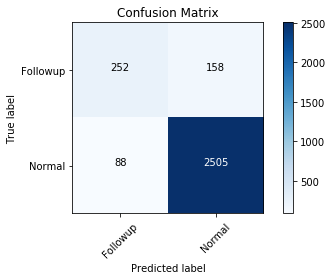

In [64]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Followup','Normal'],
                      title='Confusion Matrix')

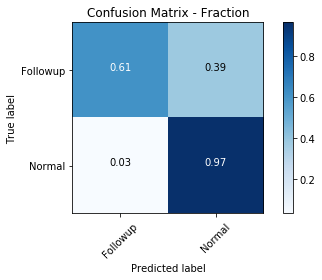

In [65]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Followup','Normal'],
                      title='Confusion Matrix - Fraction', normalize=True)

In [66]:
metrics = [binary_classifier_metrics(df['trainingLabel'], df['predicted_class'])]
df_metrics=pd.DataFrame.from_dict(metrics)
df_metrics.index = ['Model']

In [67]:
df_metrics

,Accuracy,F1,FalseNegative,FalseNegativeRate,FalsePositive,FalsePositiveRate,Negative,Positive,Precision,Recall,TrueNegative,TrueNegativeRate,TruePositive
Model,0.918082,0.672,158,0.385366,88,0.033938,2593,410,0.741176,0.614634,2505,0.966062,252


In [68]:
print('Counts')
print(df_metrics[['TruePositive',
                  'FalseNegative',
                  'FalsePositive',
                  'TrueNegative',]].round(2))
print()
print('Fractions')
print(df_metrics[['Recall',
                  'FalseNegativeRate',
                  'FalsePositiveRate',
                  'TrueNegativeRate',]].round(2))
print()

print(df_metrics[['Precision',
                  'Accuracy',
                  'F1']].round(2))

Counts
       TruePositive  FalseNegative  FalsePositive  TrueNegative
Model           252            158             88          2505

Fractions
       Recall  FalseNegativeRate  FalsePositiveRate  TrueNegativeRate
Model    0.61               0.39               0.03              0.97

       Precision  Accuracy    F1
Model       0.74      0.92  0.67


In [69]:
print(classification_report(
    df['trainingLabel'],
    df['predicted_class'],
    labels=[1,0],
    target_names=['Followup','Normal']))

              precision    recall  f1-score   support

    Followup       0.74      0.61      0.67       410
      Normal       0.94      0.97      0.95      2593

   micro avg       0.92      0.92      0.92      3003
   macro avg       0.84      0.79      0.81      3003
weighted avg       0.91      0.92      0.91      3003



In [70]:
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(df['trainingLabel'],df['predicted_prob'])
print('AUC Score: {0:.3f}'.format(roc_score))

AUC Score: 0.930


In [72]:
df = df.sort_values('trainingLabel')
df = df.reset_index(drop=True)

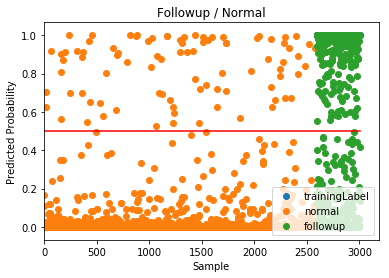

In [78]:
normal = df[df['trainingLabel']==0]
followup = df[df['trainingLabel']==1]
plt.figure()
plt.scatter(df.index,df['trainingLabel'])
plt.scatter(normal.index,normal['predicted_prob'],label='normal')
plt.scatter(followup.index,followup['predicted_prob'],label='followup')
plt.plot([df.index.min(),df.index.max()],[0.5,0.5],color='r')
plt.xlim(left=0)
plt.xlabel('Sample')
plt.ylabel('Predicted Probability')
plt.title('Followup / Normal')
plt.legend(loc=4)
plt.show()

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$50 * FN(C) + $0 * TN(C) + $10 * FP(C) + TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

Ref: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/

In [84]:
pd.crosstab(index=df['trainingLabel'],columns=np.where(df['predicted_prob'] > .5, 1, 0))

col_0,0,1
trainingLabel,,
0,2505,88
1,158,252


In [85]:
cutoffs = np.arange(0.1, .9, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 10], [50, 0]]) * 
                               pd.crosstab(index=df['trainingLabel'],columns=np.where(df['predicted_prob'] > c, 1, 0)))))

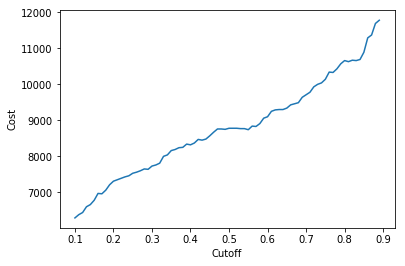

Cost is minimized near a cutoff of: 0.1 for a cost of: 6290


In [86]:
costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.ylabel('Cost')
plt.xlabel('Cutoff')
plt.show()

print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))